Using device: cuda


100%|██████████| 170M/170M [00:13<00:00, 12.2MB/s]


Training samples: 50000
Test samples: 10000
Number of classes: 10
Model architecture:
CIFAR10Classifier(
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)
Starting training...
Epoch: 1/50 | Batch: 0/391 | Loss: 2.3142
Epoch: 1/50 | Batch: 100/391 | Loss: 1.8666
Epoch: 1/50 | Batch: 200/391 | Loss: 1.7269
Epoch: 1/50 | Batch: 300/391 | Loss: 1.6678
Epoch 1/50 | Loss: 1.8568 | Accuracy: 33.28%
Epoch: 2/50 | Batch: 0/391 | Loss: 1.6537
Epoch: 2/50 | Batch: 100/391 | Loss: 1.6683
Epoch: 2/50 | Batch: 200/391 | Loss: 1.7034
Epoch: 2/50 | Batch: 300/391 | Loss: 1.6829
Epoch 2/50 | Loss: 1.6756 | Accuracy: 41.27%
Epoch: 3/50 | Batch: 0/391 | Loss: 1.6047
Epoch: 3/50 | Batch: 100/391 | Loss: 1.66

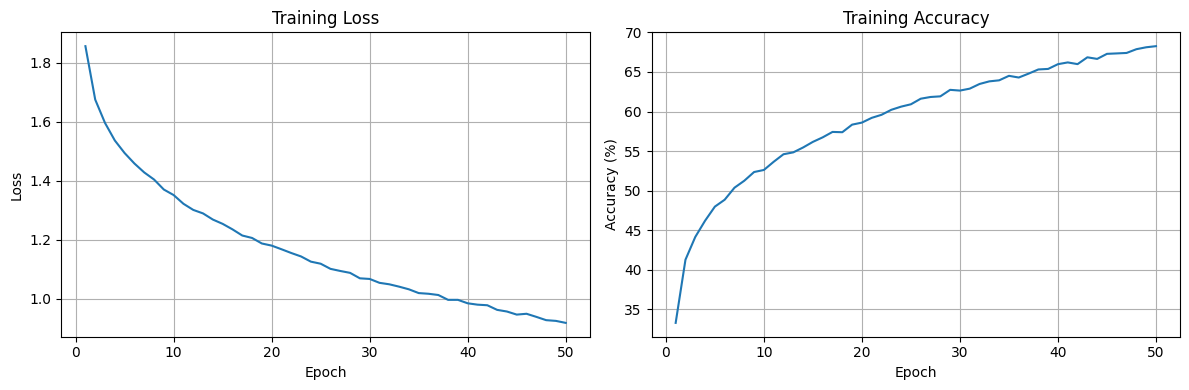


Classification Report:
              precision    recall  f1-score   support

       plane       0.59      0.67      0.62      1000
         car       0.67      0.67      0.67      1000
        bird       0.45      0.38      0.41      1000
         cat       0.36      0.39      0.37      1000
        deer       0.47      0.53      0.50      1000
         dog       0.45      0.47      0.46      1000
        frog       0.65      0.58      0.61      1000
       horse       0.67      0.57      0.61      1000
        ship       0.66      0.71      0.68      1000
       truck       0.64      0.60      0.62      1000

    accuracy                           0.56     10000
   macro avg       0.56      0.56      0.56     10000
weighted avg       0.56      0.56      0.56     10000



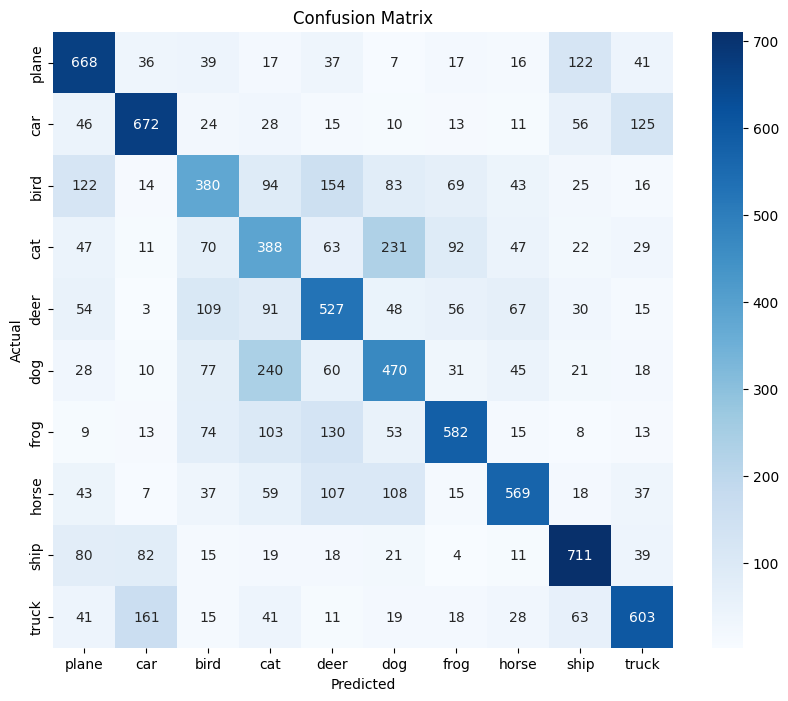


Sample predictions:


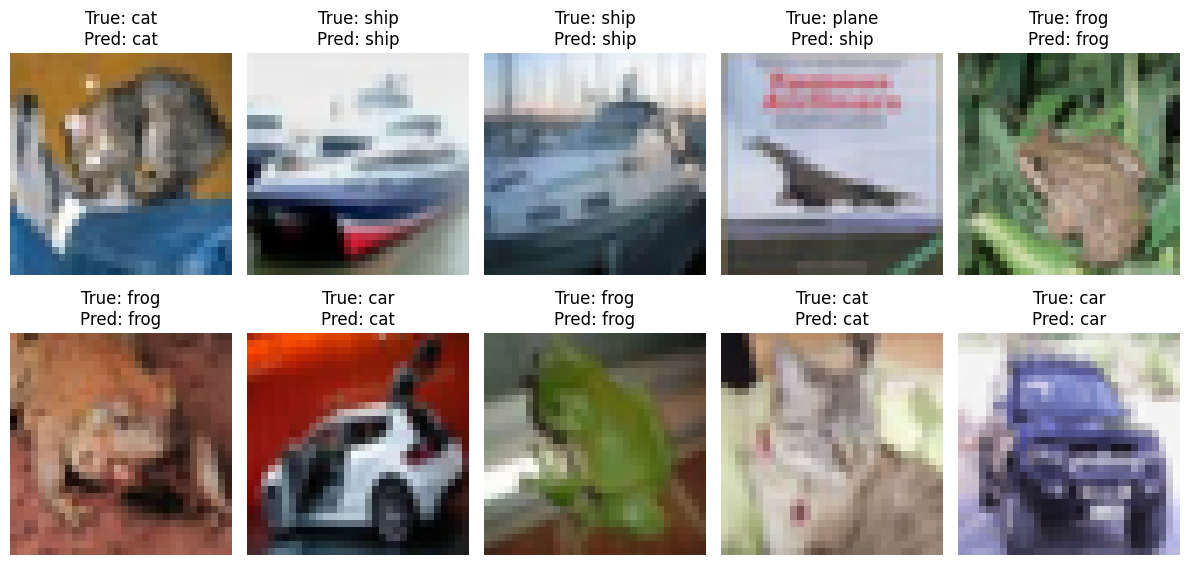

Model saved as 'cifar10_ann_model.pth'


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

# Load CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

# Create data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# CIFAR-10 classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Number of classes: {len(classes)}")

# Define the neural network architecture
class CIFAR10Classifier(nn.Module):
    def __init__(self):
        super(CIFAR10Classifier, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        x = self.fc5(x)
        return x

# Initialize the model, loss function, and optimizer
model = CIFAR10Classifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Model architecture:")
print(model)

# Training function
def train_model(model, train_loader, criterion, optimizer, epochs):
    model.train()
    train_losses = []
    train_accuracies = []

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (data, targets) in enumerate(train_loader):
            data, targets = data.to(device), targets.to(device)

            # Forward pass
            outputs = model(data)
            loss = criterion(outputs, targets)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            if batch_idx % 100 == 0:
                print(f'Epoch: {epoch+1}/{epochs} | Batch: {batch_idx}/{len(train_loader)} | Loss: {loss.item():.4f}')

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100. * correct / total

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        print(f'Epoch {epoch+1}/{epochs} | Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.2f}%')

    return train_losses, train_accuracies

# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / total

    print(f'Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.2f}%')

    return test_loss, test_accuracy, all_predictions, all_targets

# Train the model
print("Starting training...")
epochs = 50
train_losses, train_accuracies = train_model(model, train_loader, criterion, optimizer, epochs)

# Evaluate the model
print("\nEvaluating model on test set...")
test_loss, test_accuracy, predictions, targets = evaluate_model(model, test_loader)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)

plt.tight_layout()
plt.show()

# Display classification report
print("\nClassification Report:")
print(classification_report(targets, predictions, target_names=classes))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(targets, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Function to display sample predictions
def show_sample_predictions(model, test_loader, num_samples=10):
    model.eval()
    data_iter = iter(test_loader)
    images, labels = next(data_iter)
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        _, predicted = outputs.max(1)

    images = images.cpu().numpy()
    labels = labels.cpu().numpy()
    predicted = predicted.cpu().numpy()

    # Denormalize images
    images = images * 0.5 + 0.5

    plt.figure(figsize=(12, 6))
    for i in range(num_samples):
        plt.subplot(2, 5, i+1)
        plt.imshow(np.transpose(images[i], (1, 2, 0)))
        plt.title(f'True: {classes[labels[i]]}\nPred: {classes[predicted[i]]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Display sample predictions
print("\nSample predictions:")
show_sample_predictions(model, test_loader)

# Save the model
torch.save(model.state_dict(), 'cifar10_ann_model.pth')
print("Model saved as 'cifar10_ann_model.pth'")